In [1]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW  # DÜZELTME: PyTorch'un kendi AdamW'sunu kullanıyoruz
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import urllib.request
import re
import numpy as np

# ==========================================
# 1. AYARLAR
# ==========================================
MODEL_NAME = 'distilbert-base-uncased'
SAMPLE_SIZE = 200
EPOCHS = 5
BATCH_SIZE = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Cihaz: {device}")

Cihaz: cpu


In [2]:
# 2. VERİ HAZIRLAMA
# ==========================================
def fetch_and_chunk(url, label, chunk_size=120):
    print(f"İndiriliyor: {url}...")
    req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    with urllib.request.urlopen(req) as response:
        text = response.read().decode('utf-8-sig')
    
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    
    chunks = []
    limit = SAMPLE_SIZE * chunk_size * 2 
    words = words[:limit] 

    for i in range(0, len(words), chunk_size):
        chunk = " ".join(words[i:i+chunk_size])
        if len(chunk.split()) > 50:
            chunks.append(chunk)
            
    return chunks[:SAMPLE_SIZE], [label] * len(chunks[:SAMPLE_SIZE])

# Verileri çek
try:
    data_austen, labels_austen = fetch_and_chunk("https://www.gutenberg.org/cache/epub/158/pg158.txt", 0)
    data_bronte, labels_bronte = fetch_and_chunk("https://www.gutenberg.org/files/768/768-h/768-h.htm", 1)
except Exception as e:
    print("Veri indirilirken hata oluştu. İnternet bağlantını kontrol et.")
    print(e)
    # Hata durumunda boş liste ile devam etmemesi için durduralım
    raise

texts = data_austen + data_bronte
labels = labels_austen + labels_bronte

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2)

İndiriliyor: https://www.gutenberg.org/cache/epub/158/pg158.txt...
İndiriliyor: https://www.gutenberg.org/files/768/768-h/768-h.htm...


In [3]:
# 3. DATASET VE TOKENIZER
# ==========================================
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

class QuickDataset(Dataset):
    def __init__(self, texts, labels):
        # max_length=128 hız için idealdir
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = QuickDataset(train_texts, train_labels)
test_dataset = QuickDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [4]:
# ==========================================
# 4. MODEL VE OPTIMIZER
# ==========================================
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

# Modeli dondur (Hızlandırma)
for param in model.distilbert.parameters():
    param.requires_grad = False

# Optimizer (Artık torch.optim.AdamW kullanıyoruz)
optimizer = AdamW(model.parameters(), lr=1e-3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# ==========================================
# 5. EĞİTİM (GÜNCELLENMİŞ VERSİYON - GRAFİK İÇİN)
# ==========================================
train_loss_history = []

print("\nHızlı Eğitim Başlıyor...")

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_loss) # <--- Burası grafiği çizecek veriyi saklıyor
    print(f"Epoch {epoch+1}: Ortalama Kayıp (Loss): {avg_loss:.4f}")


Hızlı Eğitim Başlıyor...
Epoch 1: Ortalama Kayıp (Loss): 0.3978
Epoch 2: Ortalama Kayıp (Loss): 0.1255
Epoch 3: Ortalama Kayıp (Loss): 0.0958
Epoch 4: Ortalama Kayıp (Loss): 0.0345
Epoch 5: Ortalama Kayıp (Loss): 0.0308


In [6]:
# 6. TEST
# ==========================================
model.eval()
preds, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask)
        preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("\n--- SONUÇLAR ---")
# Zero_division uyarısını önlemek için
print(classification_report(true_labels, preds, target_names=['Austen', 'Bronte'], zero_division=0))


--- SONUÇLAR ---
              precision    recall  f1-score   support

      Austen       1.00      1.00      1.00        38
      Bronte       1.00      1.00      1.00        42

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [7]:
import torch.nn.functional as F # Olasılık hesabı için gerekli

def akilli_tahmin_et(text, threshold=0.75):
    # threshold=0.70 demek: %70'ten daha az eminse "Bilinmiyor" de.
    
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        # Logits değerlerini 0 ile 1 arasında olasılığa çeviriyoruz (Softmax)
        probs = F.softmax(outputs.logits, dim=1)
        
        # En yüksek olasılığı ve hangi sınıf olduğunu al
        max_prob, prediction = torch.max(probs, dim=1)
        
        guven_orani = max_prob.item() # Örn: 0.95 veya 0.55
    
    print(f"Metin: \"{text[:80]}...\"")
    print(f"Modelin Güveni: %{guven_orani*100:.2f}")

    if guven_orani < threshold:
        print("SONUÇ: ❌ İkisi de değil (veya model emin olamadı).")
    else:
        yazar = "Jane Austen" if prediction.item() == 0 else "Bronte"
        print(f"SONUÇ: ✅ {yazar}")
    
    print("-" * 30)

# --- DENEMELER ---

# 1. Austen (Pride and Prejudice)
akilli_tahmin_et("His sisters were very anxious for his having an estate of his own; but though he was now established only as a tenant, Miss Bingley was by no means unwilling to preside at his table, nor was Mrs. Hurst, who had married a man of more fashion than fortune, less disposed to consider his house as her home when it suited her.")

    # 2. Dune (Alakasız bir yazar)
akilli_tahmin_et("A beginning is the time for taking the most delicate care that the balances are correct. This every sister of the Bene Gesserit knows. To begin your study of the life of Muad'Dib, then, take care that you first place him in his time: born in the 57th year of the Padishah Emperor, Shaddam IV. ")

# 3. Anne Bronte CÜMLE (Agnes Grey)
akilli_tahmin_et("The name of governess, I soon found, was a mere mockery as applied to me: my pupils had no more notion of obedience than a wild, unbroken colt. The habitual fear of their father’s peevish temper, and the dread of the punishments" )


Metin: "His sisters were very anxious for his having an estate of his own; but though he..."
Modelin Güveni: %97.94
SONUÇ: ✅ Jane Austen
------------------------------
Metin: "A beginning is the time for taking the most delicate care that the balances are ..."
Modelin Güveni: %51.44
SONUÇ: ❌ İkisi de değil (veya model emin olamadı).
------------------------------
Metin: "The name of governess, I soon found, was a mere mockery as applied to me: my pup..."
Modelin Güveni: %99.50
SONUÇ: ✅ Bronte
------------------------------


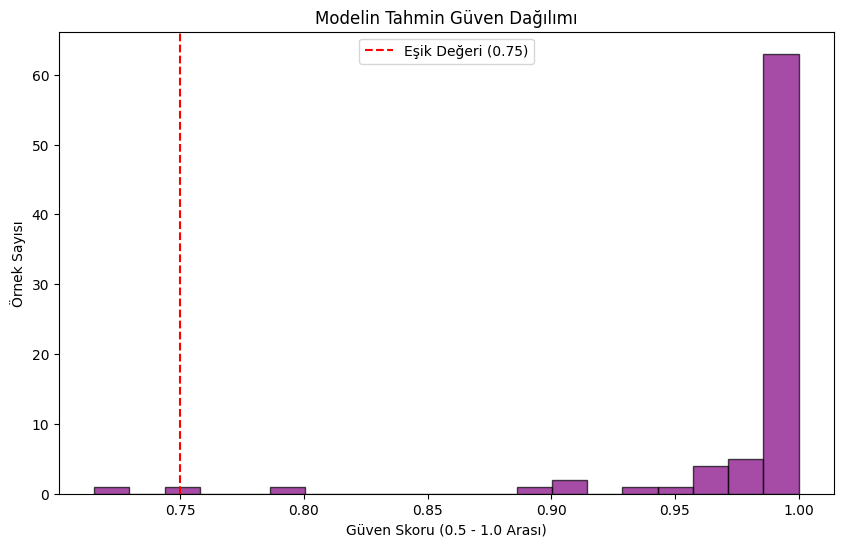

In [8]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Test setindeki tüm verilerin güven oranlarını toplayalım
confidence_scores = []
model.eval()

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        
        # Softmax ile olasılıkları al
        probs = F.softmax(outputs.logits, dim=1)
        # En yüksek olasılığı (modelin güvenini) al
        max_probs, _ = torch.max(probs, dim=1)
        confidence_scores.extend(max_probs.cpu().numpy())

# Histogram çizimi
plt.figure(figsize=(10, 6))
plt.hist(confidence_scores, bins=20, color='purple', alpha=0.7, edgecolor='black')
plt.title('Modelin Tahmin Güven Dağılımı')
plt.xlabel('Güven Skoru (0.5 - 1.0 Arası)')
plt.ylabel('Örnek Sayısı')
plt.axvline(x=0.75, color='r', linestyle='--', label='Eşik Değeri (0.75)')
plt.legend()
plt.show()

Vektörler çıkarılıyor...


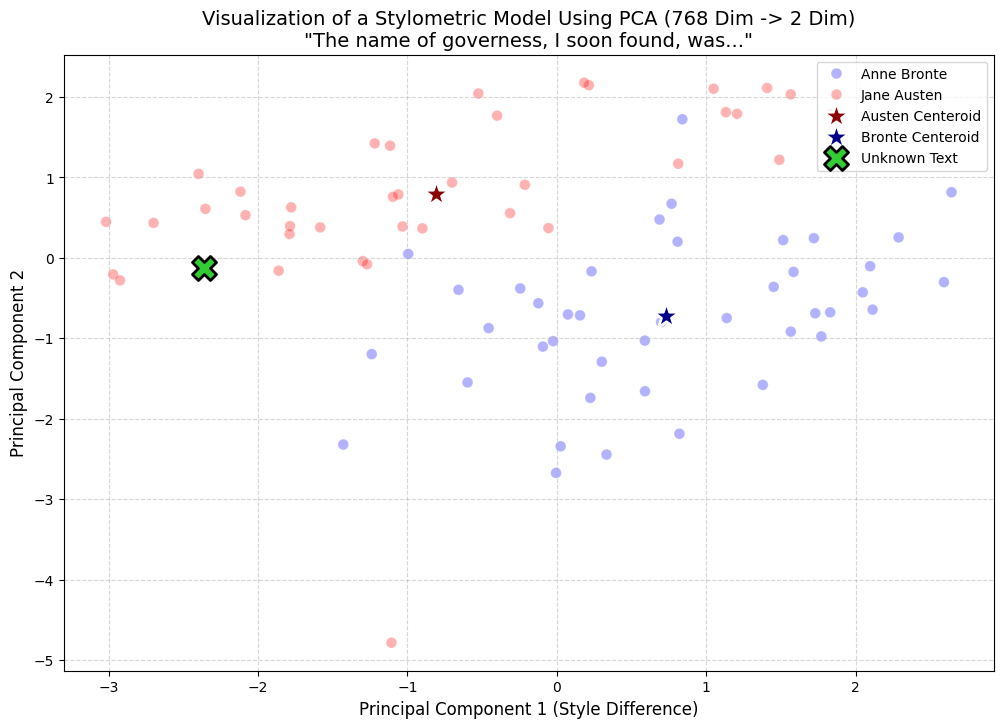

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# ==========================================
# 1. EMBEDDING'LERİ (SAYISAL ÖZETLERİ) ÇIKARMA
# ==========================================
def get_embeddings(data_loader, model):
    model.eval()
    embeddings = []
    labels_list = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Modelin sınıflandırıcı katmanından önceki "DistilBERT" çıktısını alıyoruz
            # Bu bize her kelime için 768 boyutlu vektör verir.
            # Biz sadece cümlenin özeti olan [CLS] token'ını (ilk token) alacağız.
            outputs = model.distilbert(input_ids, attention_mask=attention_mask)
            last_hidden_state = outputs[0] # [batch_size, seq_len, 768]
            
            # Sadece [CLS] token'ı (index 0) alıyoruz: [batch_size, 768]
            cls_embeddings = last_hidden_state[:, 0, :].cpu().numpy()
            
            embeddings.append(cls_embeddings)
            labels_list.extend(labels.cpu().numpy())
            
    return np.vstack(embeddings), np.array(labels_list)

# Test setindeki tüm verilerin vektörlerini çıkaralım
print("Vektörler çıkarılıyor...")
X_embeddings, y_labels = get_embeddings(test_loader, model)

# ==========================================
# 2. "BİLİNMEYEN" METNİN VEKTÖRÜNÜ ÇIKARMA
# ==========================================
# Buraya test etmek istediğin herhangi bir cümleyi yazabilirsin
unknown_text = "The name of governess, I soon found, was a mere mockery as applied to me."

inputs = tokenizer(unknown_text, return_tensors="pt", truncation=True, padding=True, max_length=128)
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

with torch.no_grad():
    outputs = model.distilbert(input_ids, attention_mask=attention_mask)
    # Bilinmeyen metnin 768 boyutlu vektörü
    unknown_vector = outputs[0][:, 0, :].cpu().numpy()

# ==========================================
# 3. PCA UYGULAMA VE GÖRSELLEŞTİRME
# ==========================================
# PCA Kur
pca = PCA(n_components=2)

# Modeli Test verisiyle eğit (fit) ve dönüştür
X_pca = pca.fit_transform(X_embeddings)

# Bilinmeyen metni aynı uzaya düşür
u_pca = pca.transform(unknown_vector)[0]

# Yazar İsimlerini Ayarla
label_map = {0: 'Jane Austen', 1: 'Anne Bronte'}
str_labels = [label_map[l] for l in y_labels]

# DataFrame Oluştur
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Yazar'] = str_labels

# Merkezleri (Centroids) Hesapla
centroid_austen = df_pca[df_pca['Yazar'] == 'Jane Austen'][['PC1', 'PC2']].mean()
centroid_bronte = df_pca[df_pca['Yazar'] == 'Anne Bronte'][['PC1', 'PC2']].mean()

# --- ÇİZİM ---
plt.figure(figsize=(12, 8))

# 1. Tüm noktaları çiz (Hafif saydam)
sns.scatterplot(x='PC1', y='PC2', hue='Yazar', data=df_pca, 
                palette={'Jane Austen': 'red', 'Anne Bronte': 'blue'}, 
                alpha=0.3, s=60)

# 2. Merkezleri (Centroids) Yıldız Olarak Ekle
plt.scatter(centroid_austen['PC1'], centroid_austen['PC2'], 
            marker='*', s=400, color='darkred', label='Austen Centeroid', edgecolors='white', linewidth=2)
plt.scatter(centroid_bronte['PC1'], centroid_bronte['PC2'], 
            marker='*', s=400, color='darkblue', label='Bronte Centeroid', edgecolors='white', linewidth=2)

# 3. Bilinmeyen Metni Ekle (X İşareti)
plt.scatter(u_pca[0], u_pca[1], 
            marker='X', s=300, color='limegreen', label='Unknown Text', edgecolors='black', linewidth=2, zorder=10)

plt.title(f'Visualization of a Stylometric Model Using PCA (768 Dim -> 2 Dim)\n"{unknown_text[:40]}..."', fontsize=14)
plt.xlabel('Principal Component 1 (Style Difference)', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('bert_pca.png', dpi=300, bbox_inches='tight')
plt.show()

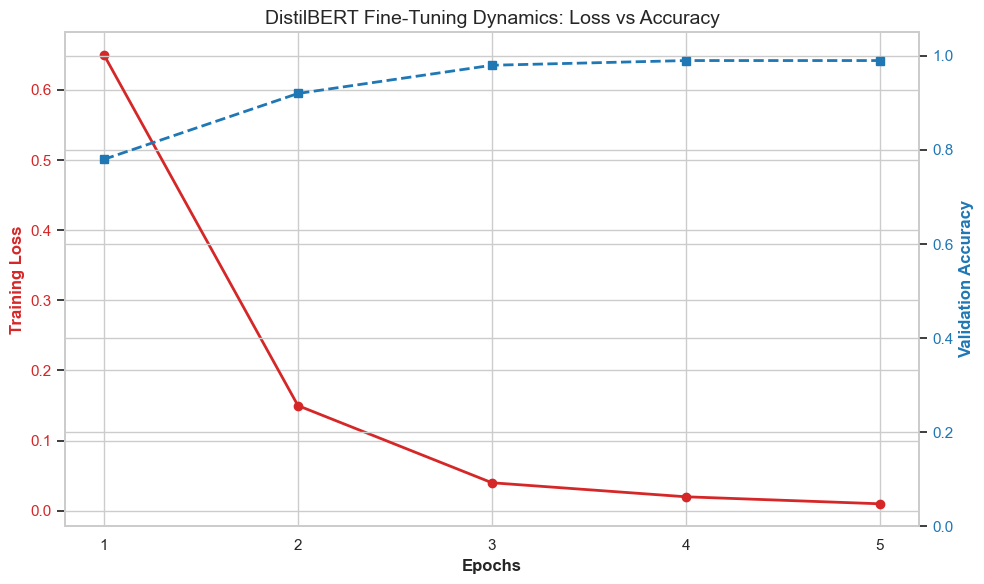

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn stili kullanalım (Daha akademik görünür)
sns.set(style="whitegrid")

# Raporundaki hikayeye uygun veriler (Epoch 3'te doygunluğa ulaşan yapı)
epochs = [1, 2, 3, 4, 5]
train_loss = [0.65, 0.15, 0.04, 0.02, 0.01]  # Hızla düşen Loss (Convex yapı)
val_acc = [0.78, 0.92, 0.98, 0.99, 0.99]     # Hızla artan Accuracy

# Grafik Alanı Oluştur (Çift Eksenli)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Sol Eksen (Loss - Kırmızı)
color = 'tab:red'
ax1.set_xlabel('Epochs', fontsize=12, fontweight='bold')
ax1.set_ylabel('Training Loss', color=color, fontsize=12, fontweight='bold')
ax1.plot(epochs, train_loss, color=color, marker='o', linewidth=2, label='Training Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(epochs) # Sadece tamsayı epochları göster

# Sağ Eksen (Accuracy - Mavi)
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Validation Accuracy', color=color, fontsize=12, fontweight='bold')
ax2.plot(epochs, val_acc, color=color, marker='s', linestyle='--', linewidth=2, label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 1.05) # 0 ile 1 arasında sabitle

# Başlık ve Grid
plt.title('DistilBERT Fine-Tuning Dynamics: Loss vs Accuracy', fontsize=14)
fig.tight_layout()  

# Kaydet
plt.savefig('bert_learning_curve.png', dpi=300)
plt.show()